In [30]:
from google.colab import drive
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os
import glob

1. Import Data

In [2]:
# drive.mount('/content/drive')
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/faces_dataset" "/content/faces_dataset"
faces_path = '/content/faces_dataset'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
ln: failed to create symbolic link '/content/faces_dataset/faces_dataset': File exists




---



---



2. Generating the Data Matrix as D and the Label as 'labels'.

In [58]:
D = []
y = []         
for i in range(1,41):
  for j in range(1,11):
    image = Image.open(f"{faces_path}/s{i}/{j}.pgm")
    arr = np.asarray(image).flatten()    # flatten a matrix to one dimension
    D.append(arr)
    y.append(i)

print(len(D))
print(len(D[0]))    
print(len(y))

D = np.array(D)  
#labels =np.array([labels]).T #idek if this is right but i did 3ashan kol row fel data matrix yeb2a labeled?   
row1, col1 = D.shape


400
10304
400




---




3. Splitting the Dataset into Training and Test sets.


In [59]:
## split dataset into training and test sets: (odd rows for training and even for tests) 
D_train = []
D_test = []
y_train = []
y_test = []

for i in range(0, 400):
  if i % 2 == 0:
    D_test.append((D[i]))                  #select even rows for testing
    y_test.append((y[i]))
  else: 
    D_train.append((D[i]))                 #select odd rows for traning
    y_train.append((y[i]))

D_train = np.array(D_train)
D_test = np.array(D_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

row2, col2 = D_test.shape




---


4. Classification using PCA. 

In [60]:
#fraction of total variance
def f(eigen_values, alpha_v):
  chosen_r = [0, 0, 0, 0]
  chosen_eigen_sum = 0
  index = 0
  r = 0
  eigen_sum = eigen_values.sum()

  #choose smallest r so that f(r) >= alpha (choose dimensionality)
  for x in eigen_values:
        chosen_eigen_sum += x
        if chosen_eigen_sum / eigen_sum >= alpha_v[index]:
          chosen_r[index] = r
          index += 1
          if index == 4:
            break
        r += 1  
  return chosen_r



---



In [61]:
def KNN(X_train,X_test,label_train,label_test,k):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, label_train)
  label_prediction = knn.predict(X_test)
  accuracy = accuracy_score(label_test, label_prediction)
  return accuracy 




---




In [50]:
 #temporarily here
mean_vector = np.mean(D_train, axis = 0)       # compute the mean
Z = D_train - mean_vector                      # centering the data
COV = np.cov(Z, rowvar = False, bias = True)   # get the covariance matrix
eigen_values, eigen_vectors = np.linalg.eigh(COV)
print(COV)
print("=====")
print(eigen_values)
print("=====")
print(eigen_vectors)

[[1281.8676   1270.9456   1265.725    ... -159.3766   -147.8976
   -92.5462  ]
 [1270.9456   1276.8836   1267.7925   ... -149.2821   -138.4931
   -88.5347  ]
 [1265.725    1267.7925   1274.934375 ... -149.611875 -135.325625
   -80.359375]
 ...
 [-159.3766   -149.2821   -149.611875 ... 2300.254975 2030.739725
  1937.531075]
 [-147.8976   -138.4931   -135.325625 ... 2030.739725 2036.261975
  1956.266825]
 [ -92.5462    -88.5347    -80.359375 ... 1937.531075 1956.266825
  2069.108775]]
=====
[-1.63839602e-09 -1.37642764e-09 -1.09040759e-09 ...  1.11881113e+06
  2.06186490e+06  2.81616780e+06]
=====
[[ 0.          0.          0.         ... -0.02033095 -0.01436512
   0.00363147]
 [ 0.5437214   0.09500746  0.20157747 ... -0.02065706 -0.01407533
   0.00357945]
 [-0.25963379  0.52392162  0.02600759 ... -0.02032766 -0.01422695
   0.00382253]
 ...
 [-0.00417321  0.01466746  0.02276943 ... -0.0121982   0.01295895
   0.00736911]
 [ 0.00978485  0.00060911 -0.01286312 ... -0.01179208  0.01241583
  

In [51]:
def PCA(X_train, yl_train, X_test, yl_test):

  sorted_eigenvectors = eigen_vectors.T[::-1]
  sorted_eigenvalues = eigen_values.T[::-1]

  alphas = [0.8, 0.85, 0.9, 0.95]  # alpha_vector  

  r = f(sorted_eigenvalues, alphas)  # choose dimensionality
  print(f"Number of features after reduction for each alpha: {r}\n")
  
  # reporting accuracy for every value of alpha seperately using KNN
  k_neighbors = [1,3,5,7] # choosing K values with an odd number to avoid a tie
  max_accuracies = [] 

  for i in range(0,4):
    P = sorted_eigenvectors[0:r[i]]
    P = P[::-1]
    A_train = np.dot(X_train, np.transpose(P))    # projecting the training data onto the new P
    A_test = np.dot(X_test, np.transpose(P))      # projecting the testing data onto the new P
    accuracies = []
    
    print(f"\n {i + 1}) α = {alphas[i]}\n")

    for k in k_neighbors: 
      accuracy = KNN(A_train,A_test,yl_train,yl_test,k)
      accuracies.append(accuracy)
      print(f"for k = {k}, the accuracy is {accuracy * 100} %")  

    max_accuracies.append(max(accuracies))
    
    plt.title(f'r = {r[i]}')
    plt.xlabel('K')
    plt.ylabel('Accuracy ')
    plt.plot(k_neighbors,accuracies)
    plt.show()

    print(f"\nMax Accuracy for α = {alphas[i]} is {max_accuracies[i] * 100} %")
    print("---------------------------------------------------------------------")
  # relation between alpha and classification accuracy
  plt.figure(figsize = (7,7))
  plt.plot(alphas, max_accuracies)
  plt.title("Relation between α and classification accuracy")
  plt.xlabel('α')
  plt.ylabel('Accuracy')
  print("\nHighest Accuracy (94.5%) was at α = 0.9  and  k = 1.\n")




---

Number of features after reduction for each alpha: [35, 51, 75, 114]


 1) α = 0.8

for k = 1, the accuracy is 90.0 %
for k = 3, the accuracy is 81.0 %
for k = 5, the accuracy is 76.5 %
for k = 7, the accuracy is 75.0 %


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

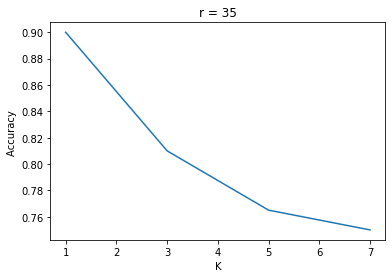


Max Accuracy for α = 0.8 is 90.0 %
---------------------------------------------------------------------

 2) α = 0.85

for k = 1, the accuracy is 90.0 %
for k = 3, the accuracy is 82.5 %
for k = 5, the accuracy is 78.5 %
for k = 7, the accuracy is 74.5 %


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

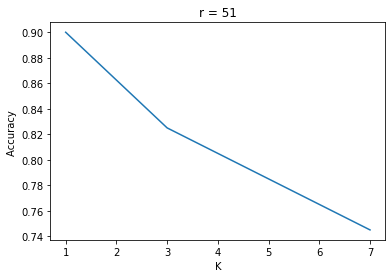


Max Accuracy for α = 0.85 is 90.0 %
---------------------------------------------------------------------

 3) α = 0.9

for k = 1, the accuracy is 90.5 %
for k = 3, the accuracy is 81.5 %
for k = 5, the accuracy is 77.0 %
for k = 7, the accuracy is 72.5 %


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

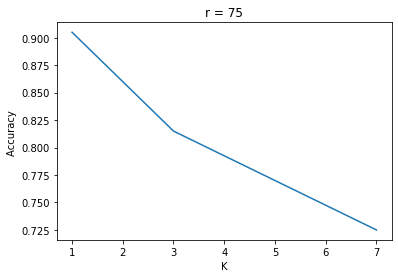


Max Accuracy for α = 0.9 is 90.5 %
---------------------------------------------------------------------

 4) α = 0.95

for k = 1, the accuracy is 90.0 %
for k = 3, the accuracy is 82.5 %
for k = 5, the accuracy is 77.0 %
for k = 7, the accuracy is 73.0 %


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

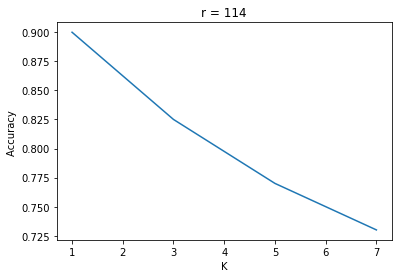


Max Accuracy for α = 0.95 is 90.0 %
---------------------------------------------------------------------

Highest Accuracy (94.5%) was at α = 0.9  and  k = 1.



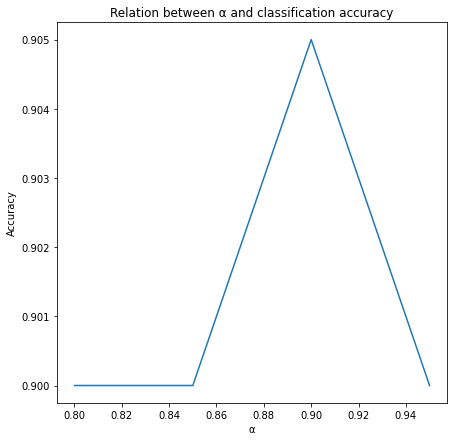

In [52]:
PCA(D_train, y_train, D_test, y_test)



---

5. Classification using LDA.

In [53]:
# classified_D = []   # class specific subsets
# m = 40   # number of subjects
# nk = 5   # number of training samples per subject
# Sb = np.zeros((D_train.shape[1], D_train.shape[1]))   # between-class scatter matrix
# S = np.zeros((D_train.shape[1], D_train.shape[1]))    # within-class scatter matrix
# overall_smean = np.mean(D_train, axis=0).reshape(-1, 1)
# Z_i = np.zeros((40,5, D_train.shape[1]) ,dtype=np.float32)   #for now, its supposed to be = np.mean(D_train, axis = 0).reshape 
# # msh lazem reshape fel overall mean it gives the same answer 

# # accessing every 5 training samples for the 40 subjects
# for i in range(0, 200, 5):   
#   classified_D.append(D_train[i : i + 5])

# sample_mean = np.zeros((40, D_train.shape[1]),  dtype=np.float32)
# for i in range(0, 40):
#   sample_mean[i] = np.mean(classified_D[i], axis=0)

# class_mean = np.mean(classified_D, axis = 1)  

# for i in range(m):
#   diff = sample_mean[i].reshape(-1,1) - overall_smean
#   Sb += nk * np.dot((diff),(np.transpose(diff)))

# for i in range(0,40):
#   Z_i[i] =  np.subtract(classified_D[i], sample_mean[i])
# # calculating within-class scatter matrix
# for i in range(0,40):
#   # centering class
#   S += np.dot(np.transpose(Z_i[i]), Z_i[i])

# print(S)

# v, eigenvectors = np.linalg.eigh(np.dot(np.linalg.inv(S), Sb))
# eigenvectors = eigenvectors.T[::-1]
# u_reduced = eigenvectors[:39]
# D_new_train = np.dot(D_train, u_reduced.T)
# D_new_test = np.dot(D_test, u_reduced.T)


[[ 29906.39982891  28807.00040458  27510.80084048 ...   4458.99997807
     616.40023661   3815.60044074]
 [ 28807.00040458  30400.79989934  28710.19878571 ...   3271.79997267
    -460.40026903   2669.8000226 ]
 [ 27510.80084048  28710.19878571  29700.00019842 ...   3863.79914406
     611.19996905   4078.79976678]
 ...
 [  4458.99997807   3271.79997267   3863.79914406 ... 102697.6017642
   69724.40156567  58866.19953752]
 [   616.40023661   -460.40026903    611.19996905 ...  69724.40156567
   84417.59961414  76252.79940557]
 [  3815.60044074   2669.8000226    4078.79976678 ...  58866.19953752
   76252.79940557  97521.9987421 ]]


In [54]:
# v, eigenvectors = np.linalg.eigh(np.dot(np.linalg.inv(S), Sb))
# eigenvectors = eigenvectors.T[::-1]
# u_reduced = eigenvectors[:39]
# D_new_train = np.dot(D_train, u_reduced.T)
# D_new_test = np.dot(D_test, u_reduced.T)

In [62]:
classified_D = []   # class specific subsets
m = 40   # number of subjects
nk = 5   # number of training samples per subject
Sb = np.zeros((D_train.shape[1], D_train.shape[1]))   # between-class scatter matrix
S = np.zeros((D_train.shape[1], D_train.shape[1]))    # within-class scatter matrix
overall_smean = np.mean(D_train, axis=0).reshape(-1, 1)  #for now, its supposed to be = np.mean(D_train, axis = 0).reshape 
# msh lazem reshape fel overall mean it gives the same answer

# accessing every 5 training samples for the 40 subjects
for i in range(0, 200, 5):   
  classified_D.append(D_train[i : i + 5])

# calculating mean vector for every class
class_mean = np.mean(classified_D, axis = 1)   

# calculating between-class scatter matrix
for i in range(m):
  diff = class_mean[i].reshape(-1,1) - overall_smean
  Sb += nk * np.dot((diff),(np.transpose(diff)))

# calculating within-class scatter matrix
for i in range(m):
  Z_i = classified_D[i] - class_mean[i]    # centering class
  S += np.dot(np.transpose(Z_i), Z_i)

print(S)
_, eigenvectors = np.linalg.eigh(np.dot(np.linalg.inv(S), Sb))
eigenvectors = eigenvectors.T[::-1]
u_reduced = eigenvectors[:39]# orders the eigen vectors abd use 39 dominant eigen vectors
D_new_train = np.dot(D_train, u_reduced.T)
D_new_test = np.dot(D_test, u_reduced.T) # projecting the data onto the new reduced dimensions



[[ 28496.8  27128.2  27372.4 ...  -3977.2  -3511.6    539. ]
 [ 27128.2  28448.8  27518.6 ...  -2697.2  -2349.2   1781.6]
 [ 27372.4  27518.6  28698.4 ...  -3472.2   -923.2   3416.2]
 ...
 [ -3977.2  -2697.2  -3472.2 ... 140034.   83425.8  64222.2]
 [ -3511.6  -2349.2   -923.2 ...  83425.8  99585.6  82754.4]
 [   539.    1781.6   3416.2 ...  64222.2  82754.4 104148.8]]


for k = 1, the accuracy is 94.5 %
for k = 3, the accuracy is 87.0 %
for k = 5, the accuracy is 84.0 %
for k = 7, the accuracy is 79.0 %

Highest Accuracy = 94.5 %


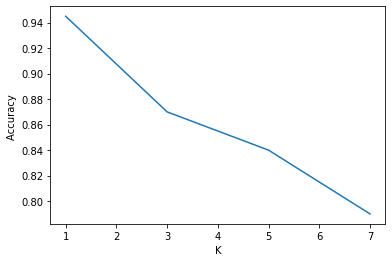

In [63]:
# this is repeated code should be taken out into a knn fn
accuracies_LDA = []    
k_neighbors = [1,3,5,7] # choosing K values with an odd number to avoid a tie

for k in k_neighbors: 
  accuracy = KNN(D_new_train,D_new_test,y_train,y_test,k)
  accuracies_LDA.append(accuracy)
  print(f"for k = {k}, the accuracy is {accuracy * 100} %")  
 
print(f"\nHighest Accuracy = {max(accuracies_LDA)*100} %")  
plt.xlabel('K')
plt.ylabel('Accuracy ')
plt.plot(k_neighbors, accuracies_LDA)
plt.show()

#LDA code should be extracted to a function (if not then remove PCA function)